In [1]:
import pandas as pd
import joblib
from catboost import Pool
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance


In [2]:
with open("../models/needed_variables.pkl", "rb") as f:
    df = joblib.load(f)

In [3]:
X = df["X_test"]
y = df["y_test"]

In [4]:
with open("../models/step2_catboost_timesplit.pkl", "rb") as f:
    model = joblib.load(f)

In [ ]:

# Identify categorical and numeric columns in the dataset
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Print out the lists of numeric and categorical column names
print(numeric_cols)
print(categorical_cols)

In [16]:


# Run permutation importance
# - model: trained classifier (e.g., RandomForestClassifier, XGBClassifier, etc.)
# - X: feature matrix
# - y: target variable (class labels)
# - n_repeats: number of times to shuffle each feature (higher = more stable estimates)
# - random_state: ensures reproducibility
# - scoring: metric for classification (e.g., "accuracy", "f1", "roc_auc")
perm_importance = permutation_importance(
    model, X, y, n_repeats=30, random_state=42, scoring='accuracy'
)

# Combine feature names and their importance scores into a DataFrame
# importances_mean: average importance score across shuffles
# importances_std: variability of importance score across shuffles
feature_names = numeric_cols + categorical_cols  
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

# Print the sorted importance values
print(importance_df)


                       feature  importance_mean  importance_std
8             num__funded_amnt         0.032290        0.001593
23              num__revol_bal         0.015575        0.000856
3                 num__bc_util         0.013078        0.000742
2          num__bc_open_to_buy         0.011617        0.000822
0              num__annual_inc         0.010260        0.000827
11   num__mo_sin_old_rev_tl_op         0.006494        0.000743
27       label__home_ownership         0.004501        0.000612
16         num__num_actv_bc_tl         0.004097        0.000636
6              num__emp_length         0.002721        0.000546
18              num__num_il_tl         0.002034        0.000414
28              label__purpose         0.001582        0.000449
24             num__revol_util         0.001538        0.000477
17              num__num_bc_tl         0.001199        0.000445
9          num__inq_last_6mths         0.000936        0.000463
13         num__mo_sin_rcnt_tl         0

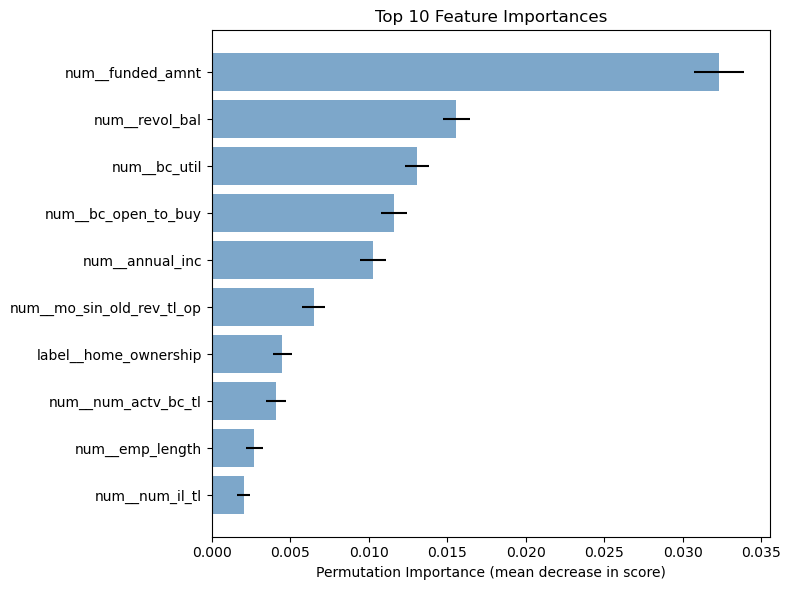

In [20]:
# Select the top 10 most important features
top10 = importance_df.head(10)

# Create a horizontal bar plot for visualization
plt.figure(figsize=(8, 6))

# Plot feature importance values with error bars
# - barh: horizontal bar chart
# - xerr: shows variability (standard deviation from permutation importance)
# - alpha: transparency for better readability
# - color: bar color
plt.barh(top10['feature'], top10['importance_mean'],
         xerr=top10['importance_std'], alpha=0.7, color='steelblue')

# Invert y-axis so the most important feature is at the top
plt.gca().invert_yaxis()

# Add axis labels and title
plt.xlabel("Permutation Importance (mean decrease in score)")
plt.title("Top 10 Feature Importances")

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()



1. num__funded_amnt is by far the strongest predictor, showing the largest mean decrease in score when permuted.
2. Other influential features include num__revol_bal, num__bc_util, num__bc_open_to_buy, and num__annual_inc.
3. Beyond the top 5, feature importance values drop off sharply, but still contribute marginally to performance.
4. Presence of label__home_ownership and num__emp_length in the top 10 shows the model also considers demographic and employment-related factors, not just financial balances

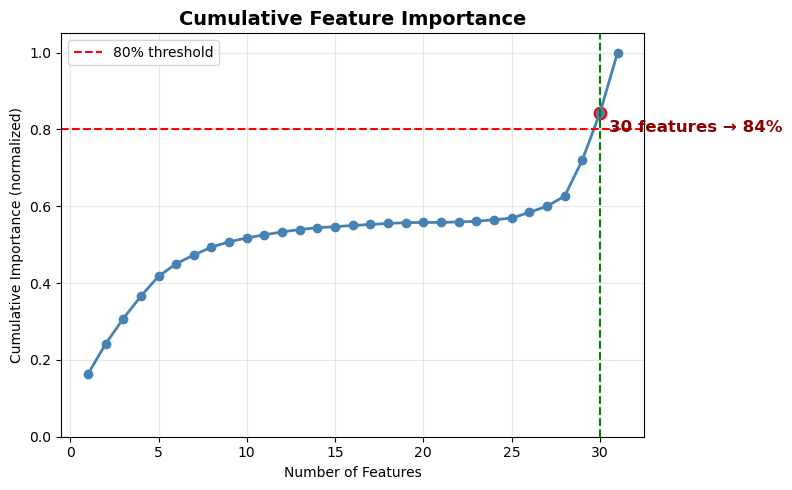

In [29]:
# Sort by mean importance
importance_df = importance_df.sort_values(by="importance_mean", ascending=False).reset_index(drop=True)

# Normalize to proportions (abs to avoid negatives breaking cumulative)
importance_df["importance_norm"] = abs(importance_df["importance_mean"]) / abs(importance_df["importance_mean"]).sum()

# Calculate cumulative (0 → 1 scale)
importance_df["cumulative"] = importance_df["importance_norm"].cumsum()

# Plot cumulative
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(importance_df)+1), importance_df["cumulative"],
         marker="o", color="steelblue", linewidth=2)

# 80% line
plt.axhline(0.8, color="red", linestyle="--", label="80% threshold")

# Cutoff marker
cutoff_idx = (importance_df["cumulative"] >= 0.8).idxmax()
cutoff_x = cutoff_idx + 1
cutoff_y = importance_df.loc[cutoff_idx, "cumulative"]
plt.axvline(cutoff_x, color="green", linestyle="--")
plt.scatter(cutoff_x, cutoff_y, color="red", s=80)
plt.text(cutoff_x+0.5, cutoff_y-0.05,
         f"{cutoff_x} features → {cutoff_y:.0%}", 
         fontsize=12, fontweight="bold", color="darkred")

# Style
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance (normalized)")
plt.title("Cumulative Feature Importance", fontsize=14, fontweight="bold")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


1. The cumulative curve rises gradually rather than steeply.
2. It takes ~30 features to cross the 80% importance threshold → predictive power is spread across many variables.
3. This indicates the model is diversified, relying on a broad set of features rather than just one or two.

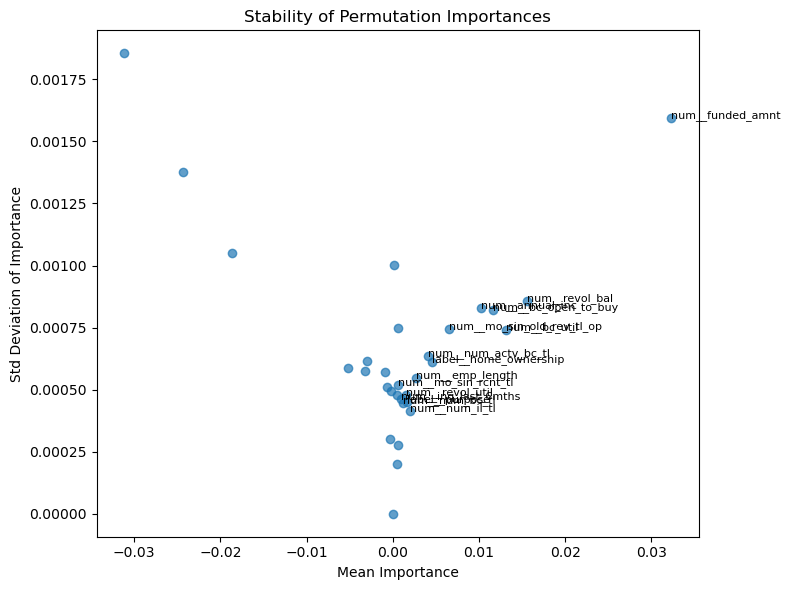

In [19]:
# Create a scatter plot to visualize the relationship between
# mean importance values and their variability (standard deviation)
plt.figure(figsize=(8, 6))

# Scatter plot of mean importance vs. standard deviation
# - alpha: transparency for better visibility of overlapping points
plt.scatter(importance_df['importance_mean'], importance_df['importance_std'], alpha=0.7)

# Annotate the top 15 most important features with their names
# - iterrows(): loop over rows
# - only labeling top 15 avoids overcrowding the chart
for i, row in importance_df.head(15).iterrows():
    plt.text(row['importance_mean'], row['importance_std'], row['feature'], fontsize=8)

# Axis labels and title
plt.xlabel("Mean Importance")
plt.ylabel("Std Deviation of Importance")
plt.title("Stability of Permutation Importances")

# Adjust layout to avoid overlaps and clipped labels
plt.tight_layout()

# Display the plot
plt.show()


1. num__funded_amnt is the dominant but somewhat variable feature.
2. Other financial balance/utilization features are moderately important and stable.
3. Most other features add little, stable contributions, confirming a long-tail distribution of minor predictors.